<a href="https://colab.research.google.com/github/hayden-huynh/Facial-Expression-Image-Classifier/blob/master/Facial_Expression_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the facial expression dataset from Kaggle
# Reference: https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

! pip install kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download samaneheslamifar/facial-emotion-expressions
! unzip facial-emotion-expressions.zip

In [2]:
# Label the dataset images into csv files

import os
import csv

label_map = {
    "angry": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 4,
    "sad": 5,
    "surprise": 6
}

train_csv = open("train_labels.csv", "w")
train_writer = csv.writer(train_csv)
test_csv = open("test_labels.csv", "w")
test_writer = csv.writer(test_csv)

train_root = "/content/images/train"
for label in sorted(os.listdir(train_root)):
  for img in sorted(os.listdir(os.path.join(train_root, label))):
    train_writer.writerow([os.path.join(label, img), label_map[label]])

test_root = "/content/images/validation"
for label in sorted(os.listdir(test_root)):
  for img in sorted(os.listdir(os.path.join(test_root, label))):
    test_writer.writerow([os.path.join(label, img), label_map[label]])


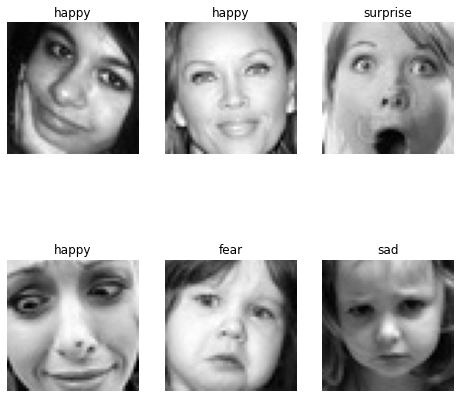

In [16]:
# Create training and testing datasets
# Reference 1: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#iterating-and-visualizing-the-dataset
# Reference 2: https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html

import os
import torch
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda
from torchvision.io import read_image
import matplotlib.pyplot as plt

classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]


# Custom dataset class
class FacialExpDataset(Dataset):
  def __init__(self, labels_csv, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(labels_csv)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path).float()
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return image, label

# Load the images into the datasets
one_hot_transform = Lambda(lambda y: torch.zeros(
    7, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
train_data = FacialExpDataset("/content/train_labels.csv", train_root, 
                              target_transform=one_hot_transform)
test_data = FacialExpDataset("/content/test_labels.csv", test_root,
                             target_transform=one_hot_transform)

# Create dataloader for the datasets
batch_size = 4
train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=True)

# Print some sample images
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[torch.argmax(label)])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


[epoch 1 | 1000/7144 batches]: loss = 1.819
[epoch 1 | 2000/7144 batches]: loss = 1.740
[epoch 1 | 3000/7144 batches]: loss = 1.662
[epoch 1 | 4000/7144 batches]: loss = 1.625
[epoch 1 | 5000/7144 batches]: loss = 1.597
[epoch 1 | 6000/7144 batches]: loss = 1.587
[epoch 1 | 7000/7144 batches]: loss = 1.563
[epoch 2 | 1000/7144 batches]: loss = 1.487
[epoch 2 | 2000/7144 batches]: loss = 1.505
[epoch 2 | 3000/7144 batches]: loss = 1.493
[epoch 2 | 4000/7144 batches]: loss = 1.502
[epoch 2 | 5000/7144 batches]: loss = 1.476
[epoch 2 | 6000/7144 batches]: loss = 1.452
[epoch 2 | 7000/7144 batches]: loss = 1.479
[epoch 3 | 1000/7144 batches]: loss = 1.409
[epoch 3 | 2000/7144 batches]: loss = 1.404
[epoch 3 | 3000/7144 batches]: loss = 1.374
[epoch 3 | 4000/7144 batches]: loss = 1.380
[epoch 3 | 5000/7144 batches]: loss = 1.397
[epoch 3 | 6000/7144 batches]: loss = 1.364
[epoch 3 | 7000/7144 batches]: loss = 1.407
[epoch 4 | 1000/7144 batches]: loss = 1.289
[epoch 4 | 2000/7144 batches]: l

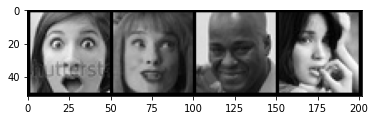

Ground Truth: surprise happy happy sad
Predicted: surprise neutral happy surprise


In [17]:
# Build the convolutional neural network, train it, and test it
# Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 5
learning_rate = 0.001


# Define the neural network class and instantiate
class ConvNeuralNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 9 * 9, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 7)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

neural_net = ConvNeuralNet()


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(neural_net.parameters(), lr=learning_rate)


# Train the network
total_batch_num = len(train_loader)
for epoch in range(num_epochs):
  running_loss = 0.0
  for i, (images, labels) in enumerate(train_loader):
    # zero the param gradients
    optimizer.zero_grad()
    
    # forward pass
    outputs = neural_net(images)
    loss = criterion(outputs, labels)

    # backward pass
    loss.backward()

    # update params w.r.t their gradients
    optimizer.step()

    # print stats
    running_loss += loss.item()
    if (i+1) % 1000 == 0:
      print(f'[epoch {epoch+1} | {i+1}/{total_batch_num} batches]: ' +
      f'loss = {running_loss/1000:.3f}')
      running_loss = 0.0
print("Training Completed")


# Test the network

# test with some data samples

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, labels = next(iter(test_loader))
imshow(make_grid(images.int()))
print('Ground Truth:', ' '.join(f'{classes[torch.argmax(labels[j])]}' 
                                 for j in range(batch_size)))

outputs = neural_net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted:', ' '.join(f'{classes[predicted[j]]}'
                              for j in range(batch_size)))


